In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
plt.style.use('seaborn-v0_8-whitegrid')
print(f"Using TensorFlow version: {tf.__version__}")

Using TensorFlow version: 2.19.0


In [6]:
# Load a subset of Fashion MNIST data for demonstration
(x_train, y_train), _ = fashion_mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
y_train = to_categorical(y_train)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Use a small subset for quick training
x_sample, _, y_sample, _ = train_test_split(x_train, y_train, train_size=5000, stratify=np.argmax(y_train, axis=1))



In [8]:
def build_and_train_model(initializer, name):
    """A helper function to build, compile, and train a model."""
    model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(128, activation='relu', kernel_initializer=initializer),
        Dense(64, activation='relu', kernel_initializer=initializer),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    print(f"\n--- Training with {name} Initializer ---")
    history = model.fit(x_sample, y_sample, epochs=10, batch_size=128, verbose=0, validation_split=0.2)
    val_acc = history.history['val_accuracy'][-1]
    print(f"Final validation accuracy: {val_acc:.4f}")
    return history

In [9]:
# Train with Zero Initializer
history_zero = build_and_train_model(tf.keras.initializers.Zeros(), "Zeros")

C:\Users\hp\anaconda3\envs\DeepLearning\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- Training with Zeros Initializer ---
Final validation accuracy: 0.0800


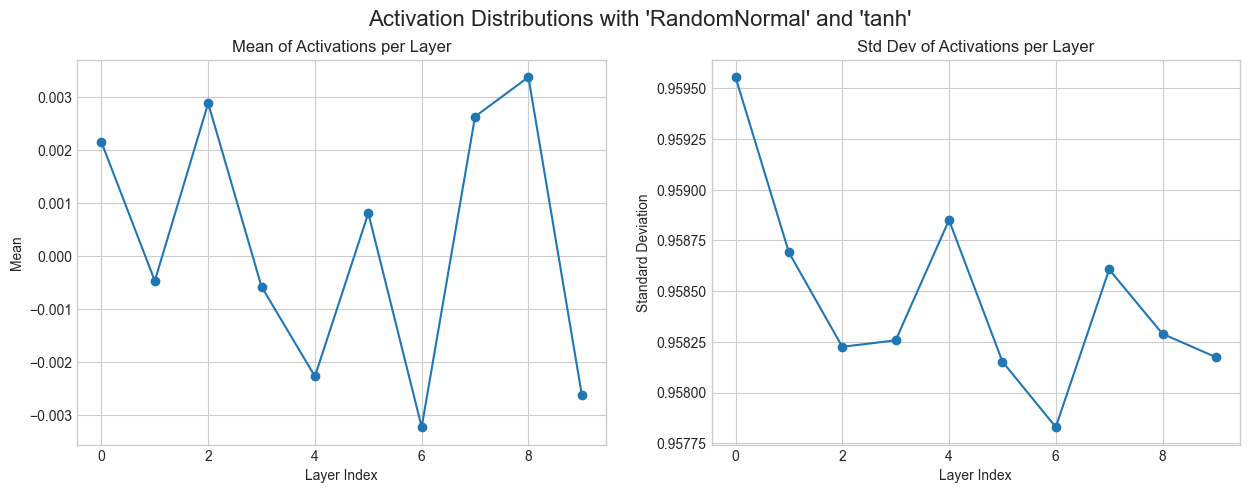

In [13]:
def plot_activation_distributions(initializer, activation_fn):
    """Plots the mean and stddev of activations across layers."""
    input_data = np.random.randn(1000, 100) # Sample input
    
    # Use the Keras Functional API for a robust solution
    # 1. Define an explicit Input tensor
    inputs = tf.keras.Input(shape=(100,))
    
    # 2. Stack layers, connecting them manually
    x = inputs
    for _ in range(10):
        x = Dense(100, kernel_initializer=initializer, activation=activation_fn)(x)
        
    # 3. Create a model from the defined input and output tensors
    model = tf.keras.Model(inputs=inputs, outputs=x)
    
    # Now that the graph is explicitly defined, we can reliably get the outputs of each layer
    layer_outputs = [layer.output for layer in model.layers[1:]] # Skip the InputLayer
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    
    activations = activation_model.predict(input_data, verbose=0)
    
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Activation Distributions with '{initializer.__class__.__name__}' and '{activation_fn}'", fontsize=16)
    
    # Plot Means and Std Devs
    means = [act.mean() for act in activations]
    stds = [act.std() for act in activations]
    
    plt.subplot(1, 2, 1)
    plt.plot(means, 'o-')
    plt.title('Mean of Activations per Layer')
    plt.xlabel('Layer Index')
    plt.ylabel('Mean')
    
    plt.subplot(1, 2, 2)
    plt.plot(stds, 'o-')
    plt.title('Std Dev of Activations per Layer')
    plt.xlabel('Layer Index')
    plt.ylabel('Standard Deviation')
    plt.show()

# Demonstrate with large random weights and tanh activation
large_random_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0)
plot_activation_distributions(large_random_init, 'tanh')

--- Using Glorot with tanh ---


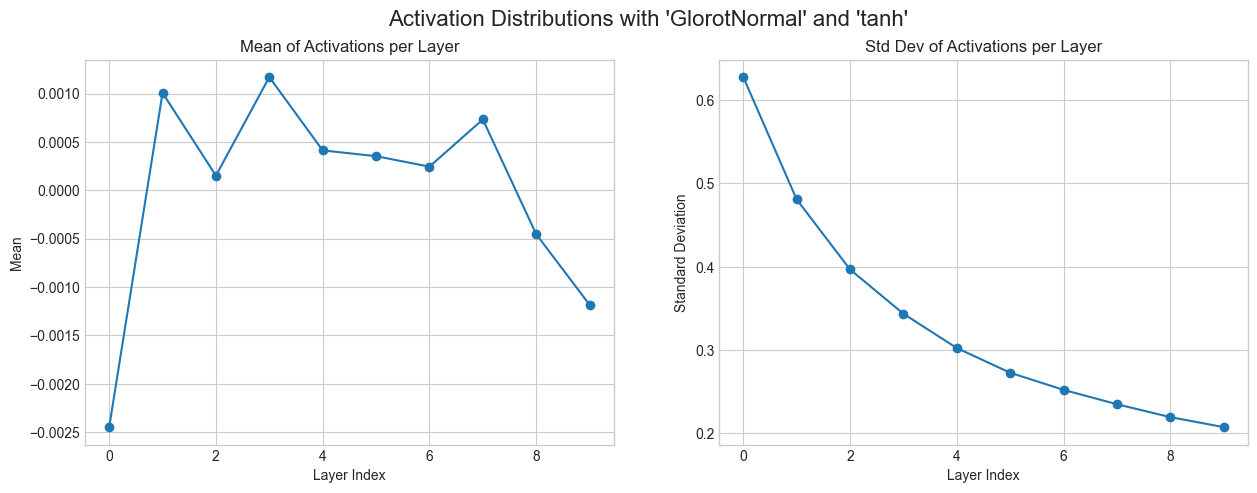


--- Using He with ReLU ---


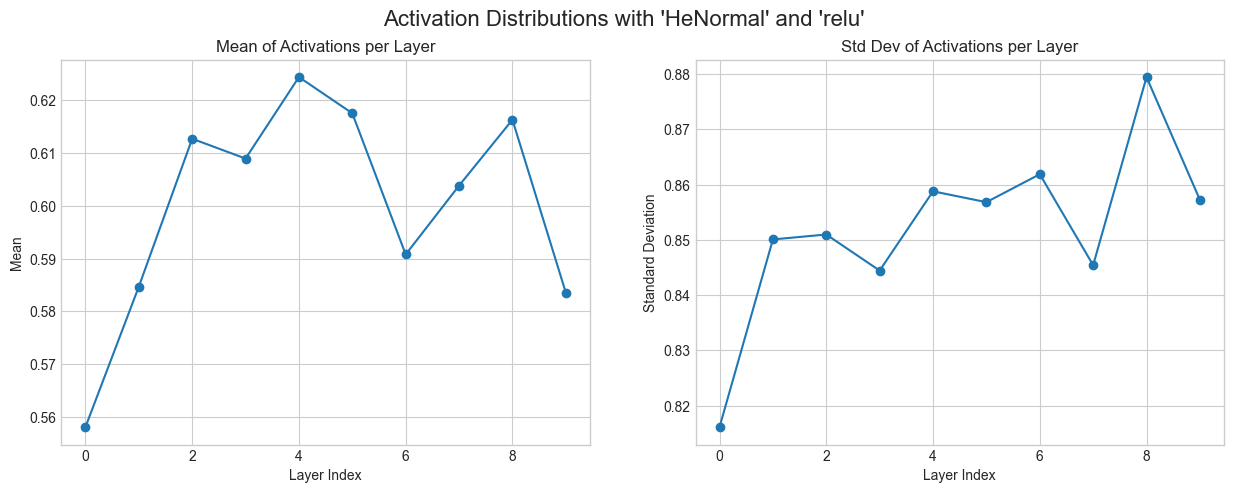

In [14]:
print("--- Using Glorot with tanh ---")
plot_activation_distributions(tf.keras.initializers.GlorotNormal(), 'tanh')

print("\n--- Using He with ReLU ---")
plot_activation_distributions(tf.keras.initializers.HeNormal(), 'relu')


--- Training with Glorot Uniform Initializer ---
Final validation accuracy: 0.7110

--- Training with He Normal Initializer ---
Final validation accuracy: 0.7440


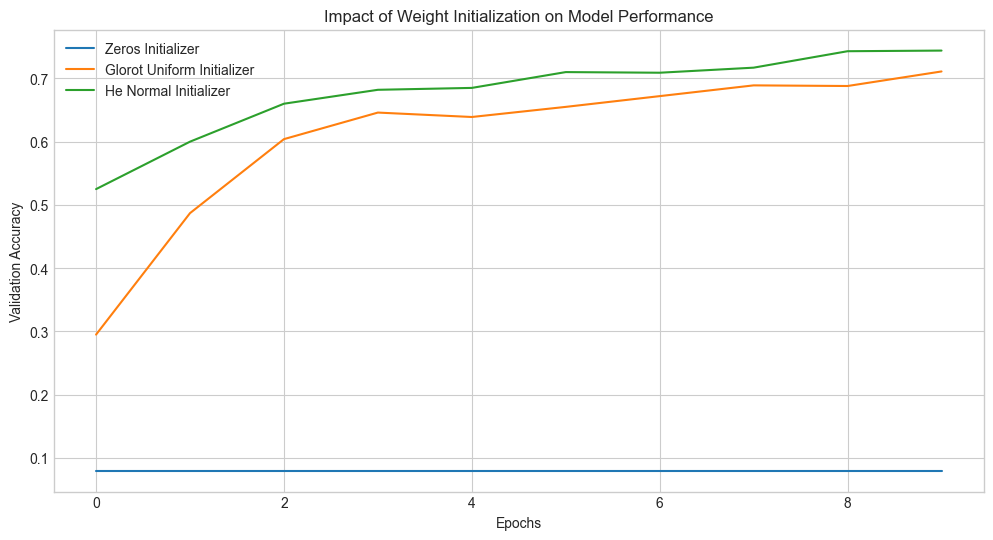

In [15]:
history_glorot = build_and_train_model(tf.keras.initializers.GlorotUniform(), "Glorot Uniform")
history_he = build_and_train_model(tf.keras.initializers.HeNormal(), "He Normal")

plt.figure(figsize=(12, 6))
plt.plot(history_zero.history['val_accuracy'], label='Zeros Initializer')
plt.plot(history_glorot.history['val_accuracy'], label='Glorot Uniform Initializer')
plt.plot(history_he.history['val_accuracy'], label='He Normal Initializer')
plt.title('Impact of Weight Initialization on Model Performance')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

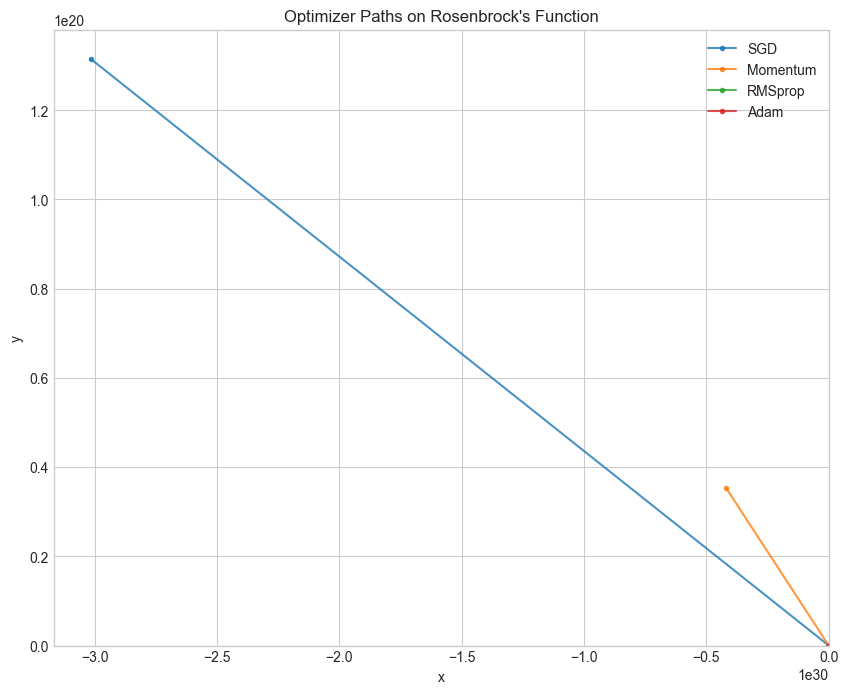

In [16]:
def beale_function(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

def rosenbrock_function(x, y):
    return (1 - x)**2 + 100 * (y - x**2)**2

def plot_optimizer_paths(loss_fn, title, x_range, y_range, start_point):
    """A helper function to visualize optimizer paths on a 2D loss surface."""
    x = np.linspace(x_range[0], x_range[1], 300)
    y = np.linspace(y_range[0], y_range[1], 300)
    X, Y = np.meshgrid(x, y)
    Z = loss_fn(X, Y)

    optimizers_to_test = {
        'SGD': tf.keras.optimizers.SGD(learning_rate=0.005),
        'Momentum': tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
        'RMSprop': tf.keras.optimizers.RMSprop(learning_rate=0.001),
        'Adam': tf.keras.optimizers.Adam(learning_rate=0.01),
    }

    plt.figure(figsize=(10, 8))
    plt.contour(X, Y, Z, levels=np.logspace(0, 5, 35), norm=plt.cm.colors.LogNorm(), cmap='viridis')
    plt.title(f'Optimizer Paths on {title}')
    plt.xlabel('x')
    plt.ylabel('y')

    for name, optimizer in optimizers_to_test.items():
        x_var = tf.Variable(start_point[0], dtype=tf.float32)
        y_var = tf.Variable(start_point[1], dtype=tf.float32)
        path = [(x_var.numpy(), y_var.numpy())]

        for _ in range(150):
            with tf.GradientTape() as tape:
                loss = loss_fn(x_var, y_var)
            grads = tape.gradient(loss, [x_var, y_var])
            optimizer.apply_gradients(zip(grads, [x_var, y_var]))
            path.append((x_var.numpy(), y_var.numpy()))

        path = np.array(path)
        plt.plot(path[:, 0], path[:, 1], 'o-', label=name, markersize=3, alpha=0.8)

    plt.legend()
    plt.show()

# Visualize on Rosenbrock's function
plot_optimizer_paths(rosenbrock_function, "Rosenbrock's Function", 
                     x_range=[-2, 2], y_range=[-1, 3], start_point=[-1.5, 2.5])

In [17]:
def train_with_optimizer(optimizer_name, optimizer_instance):
    """Helper to train a model with a specific optimizer."""
    model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(128, activation='relu', kernel_initializer='he_normal'),
        Dense(64, activation='relu', kernel_initializer='he_normal'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimizer_instance,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    print(f"\n--- Training with {optimizer_name} ---")
    history = model.fit(x_sample, y_sample, epochs=15, batch_size=128, verbose=0, validation_split=0.2)
    return history


--- Training with SGD ---

--- Training with Momentum ---

--- Training with RMSprop ---

--- Training with Adam ---


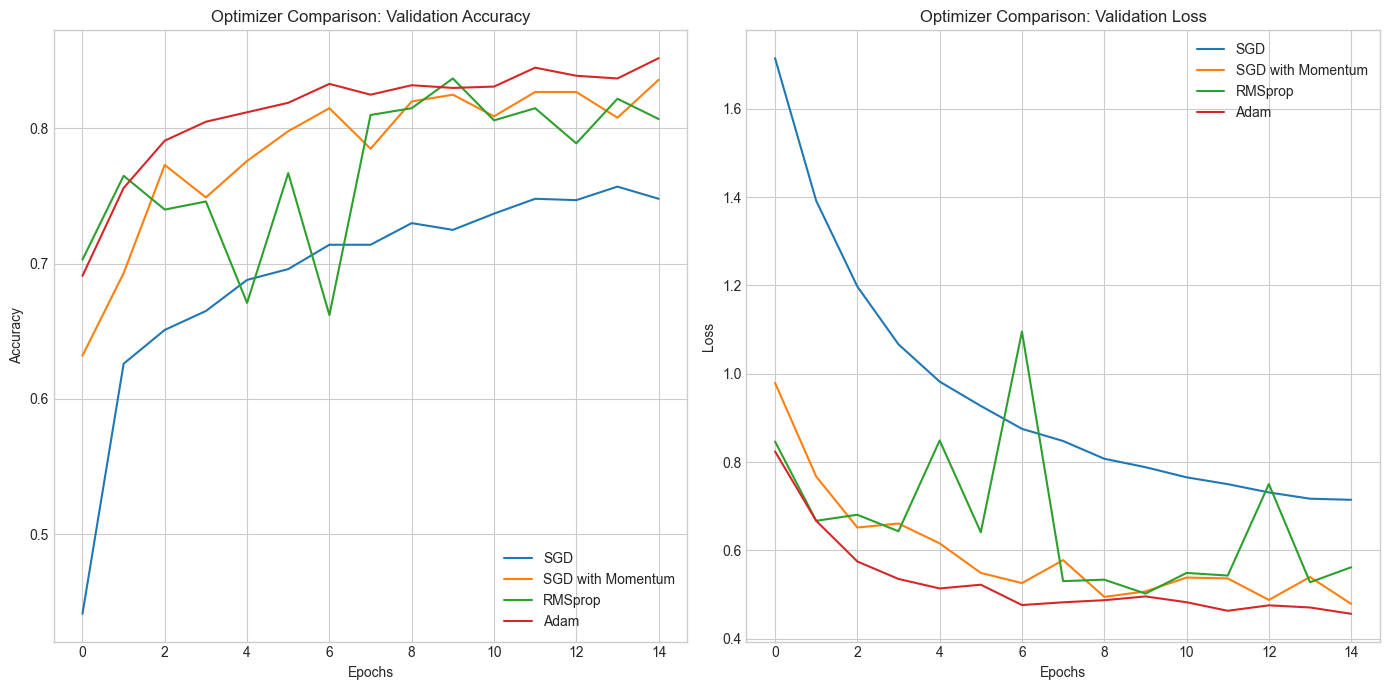

In [19]:
# Train with different optimizers
history_sgd = train_with_optimizer('SGD', tf.keras.optimizers.SGD())
history_momentum = train_with_optimizer('Momentum', tf.keras.optimizers.SGD(momentum=0.9))
history_rmsprop = train_with_optimizer('RMSprop', tf.keras.optimizers.RMSprop())
history_adam = train_with_optimizer('Adam', tf.keras.optimizers.Adam())

# Plot the results
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(history_sgd.history['val_accuracy'], label='SGD')
plt.plot(history_momentum.history['val_accuracy'], label='SGD with Momentum')
plt.plot(history_rmsprop.history['val_accuracy'], label='RMSprop')
plt.plot(history_adam.history['val_accuracy'], label='Adam')
plt.title('Optimizer Comparison: Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_sgd.history['val_loss'], label='SGD')
plt.plot(history_momentum.history['val_loss'], label='SGD with Momentum')
plt.plot(history_rmsprop.history['val_loss'], label='RMSprop')
plt.plot(history_adam.history['val_loss'], label='Adam')
plt.title('Optimizer Comparison: Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()